In [13]:
pip install geocoder

Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install foursquare

Note: you may need to restart the kernel to use updated packages.


In [272]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import foursquare as instructed
import json 

print('Libraries imported.')

Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [218]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [219]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'R32KAKWWKS4IFZFYXM3WBYYFITV4ACNMAM4HT04SYZQEKNL2' # your Foursquare ID
    CLIENT_SECRET = 'TWEGZJ5BV2LKXKET0HOSRJFRLUXKC5DKBDRMA0AUMSWXYZOR' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
            

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [220]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'R32KAKWWKS4IFZFYXM3WBYYFITV4ACNMAM4HT04SYZQEKNL2' # your Foursquare ID
    CLIENT_SECRET = 'TWEGZJ5BV2LKXKET0HOSRJFRLUXKC5DKBDRMA0AUMSWXYZOR' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [221]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [222]:
# get new york data
new_york_data=get_new_york_data()

In [223]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [224]:
new_york_data.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York

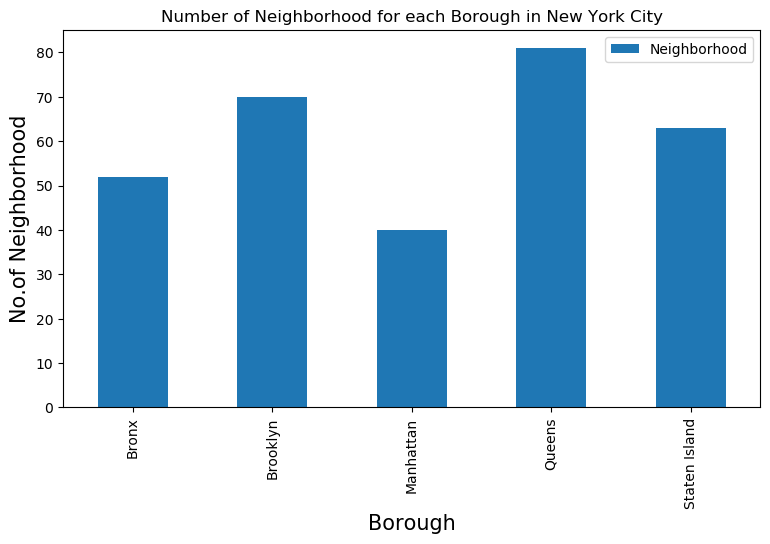

In [225]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

Now we will collect Turkish resturants for each Neighborhood

In [178]:
# prepare neighborhood list that contains turkish resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
turkish_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    turkish_resturants=venues[venues['Category']=='Turkish Restaurant']   
    print('(',count,'/',len(new_york_data),')','Turkish Resturants in '+Neighborhood+', '+Borough+':'+str(len(turkish_resturants)))
    for resturant_detail in turkish_resturants.values.tolist():
        id, name , category=resturant_detail
        turkish_rest_ny = turkish_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Turkish Resturants in Wakefield, Bronx:0
( 2 / 306 ) Turkish Resturants in Co-op City, Bronx:0
( 3 / 306 ) Turkish Resturants in Eastchester, Bronx:0
( 4 / 306 ) Turkish Resturants in Fieldston, Bronx:0
( 5 / 306 ) Turkish Resturants in Riverdale, Bronx:0
( 6 / 306 ) Turkish Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Turkish Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Turkish Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Turkish Resturants in Norwood, Bronx:0
( 10 / 306 ) Turkish Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Turkish Resturants in Baychester, Bronx:0
( 12 / 306 ) Turkish Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Turkish Resturants in City Island, Bronx:0
( 14 / 306 ) Turkish Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Turkish Resturants in University Heights, Bronx:0
( 16 / 306 ) Turkish Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Turkish Resturants in Fordham, Bronx:0
( 18 / 306 ) Turkish Resturants in East Tremont, Bronx:

Now that we have got all the turkish resturants in new york city , we will analyze it

In [226]:
turkish_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Brooklyn,Bay Ridge,579d3e7c498effa33c0450af,Istanbul Bay
1,Brooklyn,Bay Ridge,4d420ba9f0dba1cd6c752f49,Hazar Turkish Kebab
2,Brooklyn,Gravesend,51a2a2a3498e0d5d337f137b,Wood Spoon
3,Brooklyn,Sheepshead Bay,4fcbfc92e4b088c92e7e97ad,Opera Cafe Lounge
4,Brooklyn,Sheepshead Bay,4b1d5405f964a520d70e24e3,Liman Restaurant


In [227]:
turkish_rest_ny.shape

(31, 4)

We got __31__ Turkish Resturants across New York City

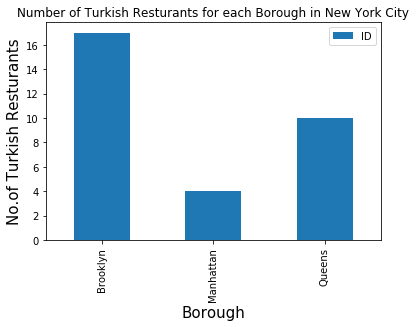

In [228]:
# title
plt.title('Number of Turkish Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Turkish Resturants', fontsize=15)
#giving a bar plot
turkish_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Brooklyn has the largest number of turkish resturants

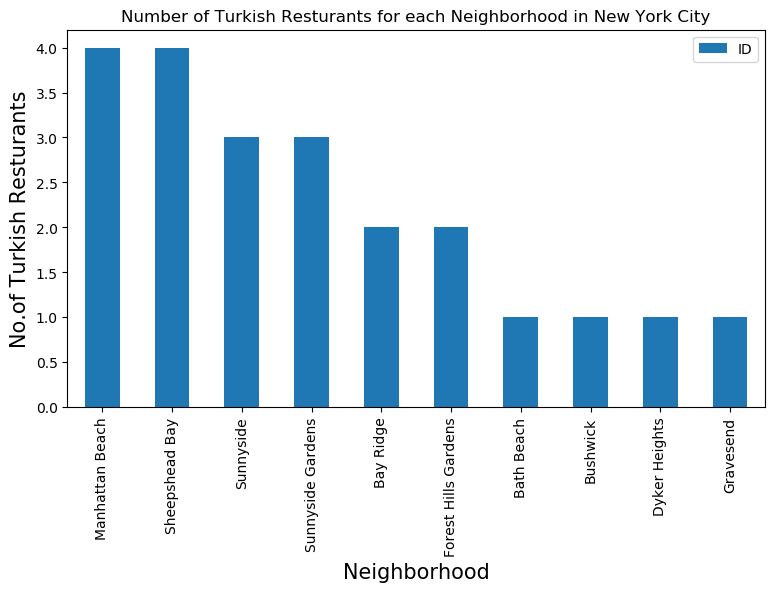

In [276]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Turkish Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Turkish Resturants', fontsize=15)
#giving a bar plot
turkish_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(10).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [230]:
turkish_rest_ny[turkish_rest_ny['Neighborhood']=='Manhattan Beach']

,Borough,Neighborhood,ID,Name
10,Brooklyn,Manhattan Beach,4b1d5405f964a520d70e24e3,Liman Restaurant
11,Brooklyn,Manhattan Beach,4fcbfc92e4b088c92e7e97ad,Opera Cafe Lounge
12,Brooklyn,Manhattan Beach,53800e9c498e1b7adfbaaf5d,Rocca Cafe & Lounge
13,Brooklyn,Manhattan Beach,4a986cf5f964a520f32b20e3,Istanbul Restaurant Fish & Kebab


So Mannhattan Beach in Brooklyn has the highest number of Turkish Resturants with a total count of __4__.

Now we will get the ranking of each resturant for further analysis.

In [286]:
# prepare neighborhood list that contains turkish resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
turkish_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in turkish_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(turkish_rest_ny),')','processed')
    turkish_rest_stats_ny = turkish_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

No data available for id= 579d3e7c498effa33c0450af
( 1 / 31 ) processed
No data available for id= 4d420ba9f0dba1cd6c752f49
( 2 / 31 ) processed
No data available for id= 51a2a2a3498e0d5d337f137b
( 3 / 31 ) processed
No data available for id= 4fcbfc92e4b088c92e7e97ad
( 4 / 31 ) processed
No data available for id= 4b1d5405f964a520d70e24e3
( 5 / 31 ) processed
No data available for id= 53800e9c498e1b7adfbaaf5d
( 6 / 31 ) processed
No data available for id= 4a986cf5f964a520f32b20e3
( 7 / 31 ) processed
No data available for id= 4a060d32f964a520b1721fe3
( 8 / 31 ) processed
No data available for id= 5c6f413778782c002c8e3e23
( 9 / 31 ) processed
No data available for id= 5b3cf64625ecca003929c841
( 10 / 31 ) processed
No data available for id= 4b1d5405f964a520d70e24e3
( 11 / 31 ) processed
No data available for id= 4fcbfc92e4b088c92e7e97ad
( 12 / 31 ) processed
No data available for id= 53800e9c498e1b7adfbaaf5d
( 13 / 31 ) processed
No data available for id= 4a986cf5f964a520f32b20e3
( 14 / 31

In [287]:
turkish_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Bay Ridge,0,0,0,0,0
1,Brooklyn,Bay Ridge,0,0,0,0,0
2,Brooklyn,Gravesend,0,0,0,0,0
3,Brooklyn,Sheepshead Bay,0,0,0,0,0
4,Brooklyn,Sheepshead Bay,0,0,0,0,0


In [282]:
turkish_rest_stats_ny.shape

(31, 7)

In [283]:
turkish_rest_ny.shape

(31, 4)

So we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [237]:
turkish_rest_stats_ny.to_csv('turkish_rest_stats_ny.csv', index=False)


Lets verify the data from saved csv file

In [238]:
turkish_rest_stats_ny_csv=pd.read_csv('turkish_rest_stats_ny.csv')


In [239]:
turkish_rest_stats_ny_csv.shape

(31, 7)

In [240]:
turkish_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Bay Ridge,0,0,0,0,0
1,Brooklyn,Bay Ridge,0,0,0,0,0
2,Brooklyn,Gravesend,0,0,0,0,0
3,Brooklyn,Sheepshead Bay,0,0,0,0,0
4,Brooklyn,Sheepshead Bay,0,0,0,0,0


In [241]:
turkish_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 7 columns):
Borough         31 non-null object
Neighborhood    31 non-null object
ID              31 non-null object
Name            31 non-null object
Likes           31 non-null object
Rating          31 non-null object
Tips            31 non-null object
dtypes: object(7)
memory usage: 1.8+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [242]:
turkish_rest_stats_ny['Likes']=turkish_rest_stats_ny['Likes'].astype('float64')

In [243]:
turkish_rest_stats_ny['Rating']=turkish_rest_stats_ny['Rating'].astype('float64')

In [244]:
turkish_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 7 columns):
Borough         31 non-null object
Neighborhood    31 non-null object
ID              31 non-null object
Name            31 non-null object
Likes           31 non-null float64
Rating          31 non-null float64
Tips            31 non-null object
dtypes: float64(2), object(5)
memory usage: 1.8+ KB


Now the data types looks correct

In [245]:
# Resturant with maximum Likes
turkish_rest_stats_ny.iloc[turkish_rest_stats_ny['Likes'].idxmax()]

Borough          Brooklyn
Neighborhood    Bay Ridge
ID                      0
Name                    0
Likes                   0
Rating                  0
Tips                    0
Name: 0, dtype: object

In [246]:
# Resturant with maximum Rating
turkish_rest_stats_ny.iloc[turkish_rest_stats_ny['Rating'].idxmax()]

Borough          Brooklyn
Neighborhood    Bay Ridge
ID                      0
Name                    0
Likes                   0
Rating                  0
Tips                    0
Name: 0, dtype: object

In [247]:
# Resturant with maximum Tips
turkish_rest_stats_ny.iloc[turkish_rest_stats_ny['Tips'].idxmax()]

TypeError: reduction operation 'argmax' not allowed for this dtype

Now lets visualize neighborhood with maximum average rating of resturants

In [248]:
ny_neighborhood_stats=turkish_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [249]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
0,Bath Beach,0.0
10,Park Slope,0.0
17,Upper West Side,0.0
16,Turtle Bay,0.0
15,Sunnyside Gardens,0.0
14,Sunnyside,0.0
13,Steinway,0.0
12,Sheepshead Bay,0.0
11,Ravenswood,0.0
9,Ocean Parkway,0.0


Above are the top neighborhoods with top average rating of Turkish resturants

In [250]:
ny_borough_stats=turkish_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [251]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Brooklyn,0.0
1,Manhattan,0.0
2,Queens,0.0


Similarly these are the average rating of Turkish Resturants for each Borough

Lets visualize it

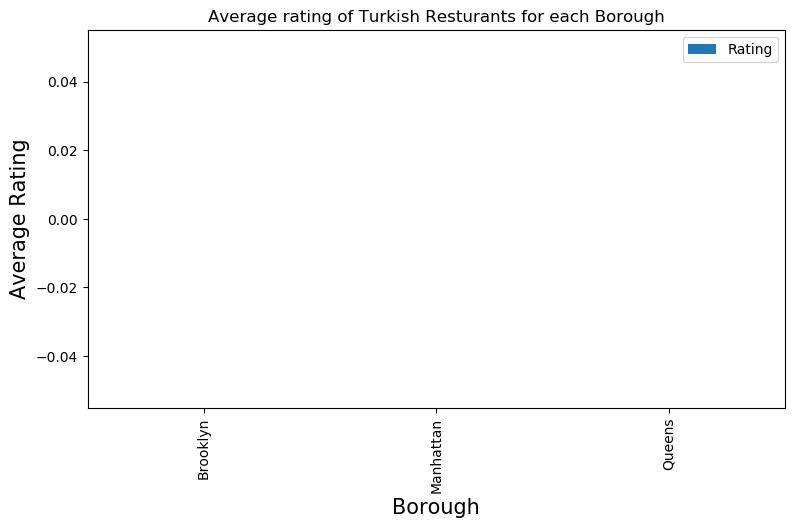

In [252]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Turkish Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
turkish_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [254]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [255]:
ny_neighborhood_stats

,Neighborhood,Average Rating


We will join this dataset to original new york data to get lonitude and latitude

In [256]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [257]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [258]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating


Now we will show this data on a map

In [259]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [260]:
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose

In [261]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [262]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighborhoods.
Lets Visualize Boroughs based on average Rating

In [275]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

FileNotFoundError: [Errno 2] No such file or directory: 'Borough Boundaries.geojson'